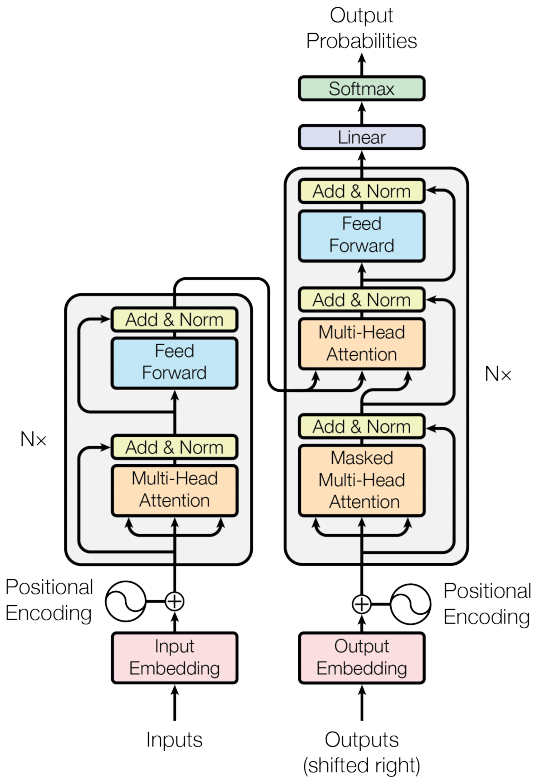
Transformer 的结构图如上，主要分为 Encoder 和 Decoder。Encoder有6层，每层都由两个子层组成（Multi-head attention 和 Position-wise Feed-Forward network），每个子层后都使用了dropout、残差和层归一化。Decoder也有6层，每层都由3个子层组成（两个Multi-head attention 和一个 Position-wise Feed-Forward network），同样的，每个子层后都使用了dropout、残差和层归一化。

# Word embedding
源语句（Inputs）和目标语句（Outputs）都要经过word_embedding，将每个单词（用整数表示）映射成 d_model 维的词向量，论文中d_model = 512，同时让embedding 层的所有权重乘以 $\sqrt{d\_model}$，乘以 $\sqrt{d\_model}$ 的原因在之后解释

In [1]:
import torch
import torch.nn as nn

class Embeddings(nn.Module):
    
    def __init__(self, d_model, vocab_size):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embed(x) * (self.d_model ** 0.5)


ModuleNotFoundError: No module named 'torch'

# Positional encoding
我们知道，一个英文句子，如果所使用的单词是一样的，但是单词的顺序不同，那么语义就会不一样甚至完全相反，因此模型必须感知到位置信息。以往的 RNN Language Model由于语句序列串行输入，天然地能让模型感知到词的相对顺序。transformer的特点之一就是不使用RNN，encoder 的词向量序列并行输入，因此需要给词向量加入关于位置的信息。在实现方式上，分为Facebook版本（《Convolutional Sequence to Sequence Learning》）和Google版本。作者形容前者为“learned and fixed”，即“Postional Embedding”，它只能表征有限长度内的位置，无法对任意位置进行建模，不过后来 BERT 使用的是学习到的位置编码。而后者直接上了公式，改“Embedding”为“Encode”，想要多长就有多长。实验结果表明，两种形式的模型没有效果差别，但毕竟通过公式来计算更简单、参数量也更小。简单来说就是生成一个 d_model 维的位置编码，与词向量序列相加。下式中 pos 表示位置， i 表示维度。

$$\begin{aligned} PE_{(pos, 2i)} &=\sin \left(\operatorname{pos} / 10000^{2 i / d_{\text {model }}}\right) \\ PE_{(pos, 2i+1)} &=\cos \left(\operatorname{pos} / 10000^{2i / d_{\text {model }}}\right) \end{aligned}$$

- 使用正余弦函数的原因是：相隔 k 个词的两个位置 pos 和 pos+k 的位置编码是由 k 的位置编码定义的一个线性变换，这样可以表达出词之间的距离

$$\begin{aligned}
&P E_{(\text {pos}+k, 2 i)}=P E_{(\text {pos}, 2 i)} P E_{(k, 2 i+1)}+P E_{(\text {pos}, 2 i+1)} P E_{(k, 2 i)}\\
&P E_{(\text {pos}+k, 2 i+1)}=P E_{(\text {pos}, 2 i+1)} P E_{(k, 2 i+1)}-P E_{(\text {pos}, 2 i)} P E_{(k, 2 i)}
\end{aligned}$$

- 为什么要在不同的维度上使用不同的波长？假设使用的如下的位置编码公式：

$$P E(p o s)=\sin \left(\frac{p o s}{\alpha}\right)$$

其中$\alpha$用来调节位置编码函数的波长。如果$\alpha$比较大，相邻字符之间的位置差异体现得不明显；如果$\alpha$比较小，在长文本中还是可能会有一些不同位置的字符的编码一样。既然字嵌入的维度是 d_model ，自然也可以使用一个 d_model 维向量来表示某个位置编码。显然，在不同维度上应该用不同的函数操纵位置编码，这样高维的表示空间才有意义。可以为位置编码的每一维赋予不同的$\alpha$；甚至在一些维度将 sin 替换为 cos ...这种构造方法就是论文中的方法


- 设置奇偶下标 2i 和 2i + 1不是必要的，只要能体现出位置信息就可以了。官方代码 tensor2tensor 的最初版本只是简单地分了前后两段
```python
PE(pos, 0:channels/2) = sin(scaled_time)
PE(pos, channels/2:) = cos(scaled_time) 
```

In [ ]:
import numpy as np
from torch.autograd import Variable

class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, max_seq_len=100):
        super().__init__()
        
        position_encoding = np.array([
            [pos / (10000 ** (2.0 * (i // 2) / d_model)) for i in range(d_model)]
            for pos in range(max_seq_len)
        ])
        position_encoding[:, 0::2] = np.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = np.cos(position_encoding[:, 1::2])
        # self.position_encoding: [1, max_seq_len, d_model]
        self.position_encoding = torch.FloatTensor(position_encoding).unsqueeze(0)        
        
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        """
        Args:
            x: [BATCH_SIZE, seq_len, d_model]
            
        return:
            output: [BATCH_SIZE, seq_len, d_model]
        """
        x = x + Variable(self.position_encoding[:, :x.size(1)], requires_grad=False)
        output = self.dropout(x)
        return output

# Scaled dot-product attention
在 Q&A 任务中：K 是 question，V 是 answer，Q 是新来的 question，看看历史中 Q 和哪个 K 更相似，根据相似 K 对应的 V，生成当前 question 的 answer。

而在机器翻译任务中，很自然地，我会想到：K 是源语句，V 是目标语句，Q 是新来的源语句，看看 Q 和哪个 K 更相似，根据相似 K 对应的 V，生成当前源语句 Q 的目标语句。

但是要注意，在训练过程中，目标语句也是模型的输入。Transformer 使用的是基于语义的注意力模型：使用自注意力（self attention）机制分别学习源语句和目标语句的语义，然后使用上下文注意力（context attention）机制学习源语义和目标语义的关系。

- 在 encoder 的 self-attention 中，Q、K、V 都来自同一个地方，它们是上一层 encoder 的输出。对于第一层 encoder，它们就是 word embedding 和 positional encoding 相加得到的输入。
- 在 decoder 的 self-attention 中，Q、K、V 也是自于同一个地方，它们是上一层 decoder 的输出。对于第一层 decoder，同样也是 word embedding 和 positional encoding 相加得到的输入。但是对于 decoder，我们不希望它能获得下一个 time step (即将来的信息，不想让他看到它要预测的信息)，因此我们需要进行 sequence masking。
- 在 encoder-decoder attention 中，Q 来自于 decoder 的上一层的输出，K 和 V 来自于 encoder 的输出，K 和 V 是一样的。

在自注意力模型中，q,k,v 都是输入语句，目标是学习同一句子不同位置之间的关联，如下面的例子：红色为当前单词，蓝色的深浅表示与当前词的关联强弱：
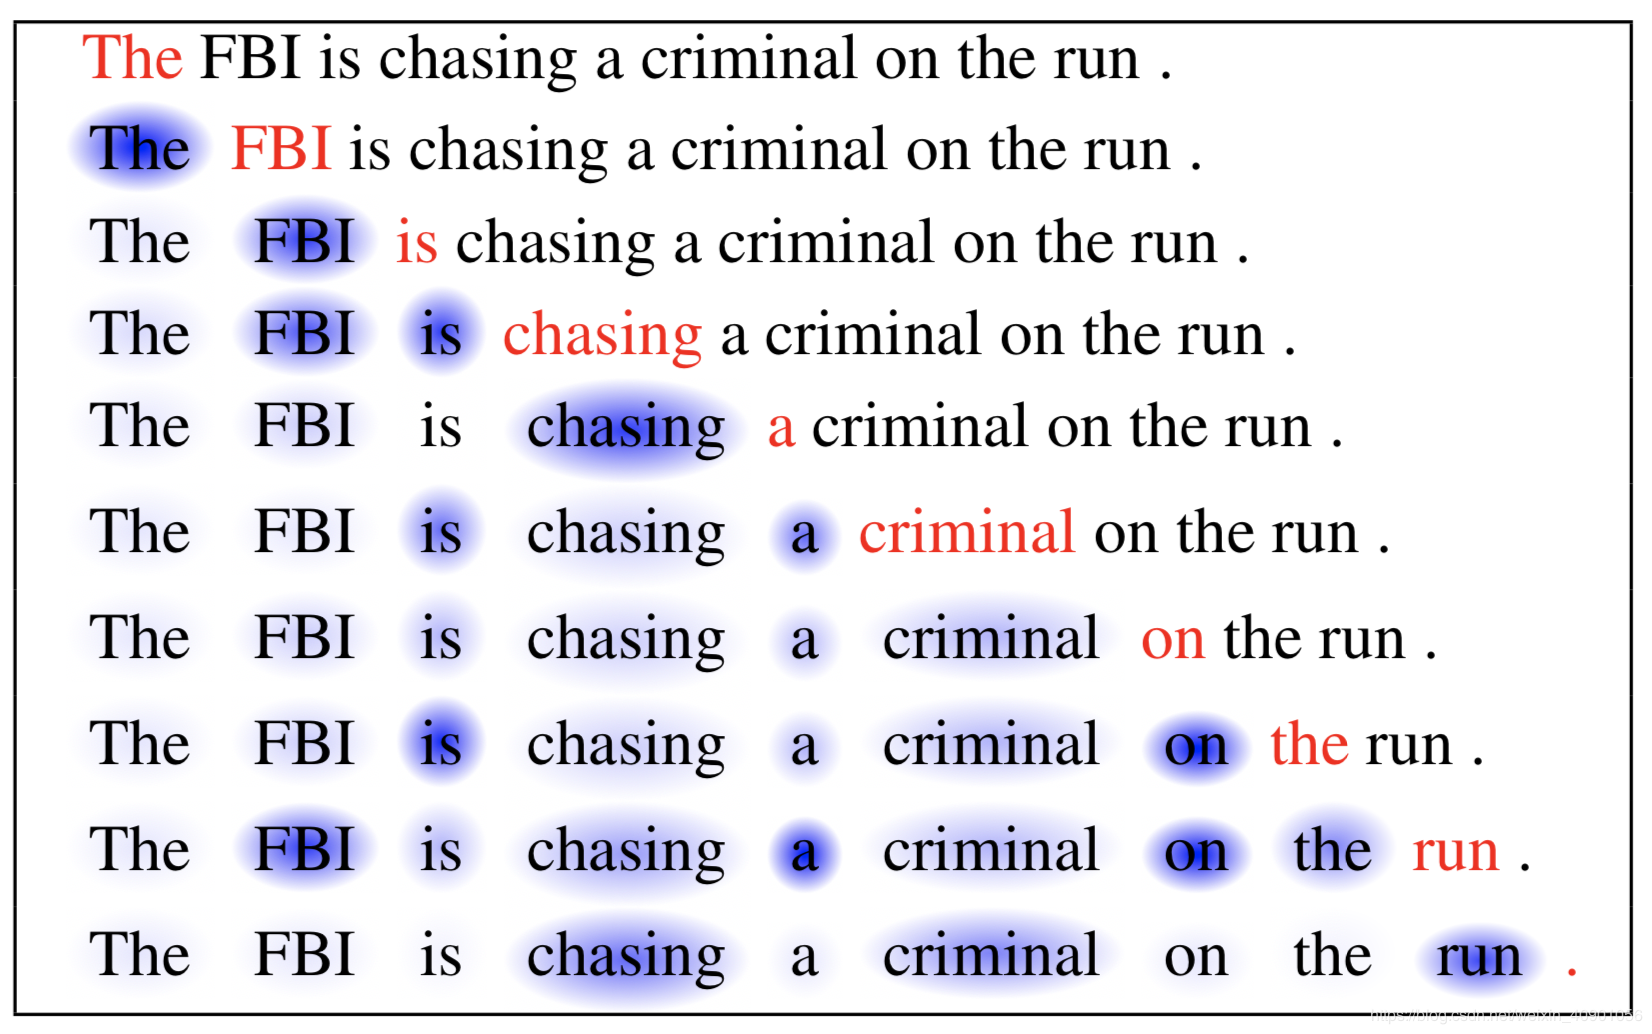
为什么使用自注意力机制？论文中的描述是：
> One is the total computational complexity per layer. Another is the amount of computation that can be parallelized, as measured by the minimum number of sequential operations required.
The third is the path length between long-range dependencies in the network.... The shorter these paths between any combination of positions in the input and output sequences, the easier it is to learn long-range dependencies

而上下文注意力较好理解，就是 encoder 和 decoder 之间的注意力。

计算attention的时候，可以选择很多方式，transformer 使用含缩放因子的点积注意力：
$$\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$$

为了防止 d_k 过大导致 softmax 后的值处于饱和区域，使用缩放因子。同时需要屏蔽掉与特殊字符有关的 attention，具体做法是在 softmax 前把有关的值设为 -∞

In [ ]:
import torch.nn.functional as F

def sdp_attention(q, k, v, dropout=None, mask=None):
    """
    Args:
        q: [BATCH_SIZE, n_heads, seq_len, d_q]
        k: [BATCH_SIZE, n_heads, seq_len, d_k]
        v: [BATCH_SIZE, n_heads, seq_len, d_v]
        dropout: a dropout layer
        mask: [BATCH_SIZE, 1, seq_len, seq_len] ByteTensor, 
              in Encoder: mask out all the attention relate to <pad>
              in Decoder: mask out all the attention relate to <pad> and the subsequence position
    return:
        output: [BATCH_SIZE, n_heads, seq_len, d_v]
        attention: [BATCH_SIZE, n_heads, seq_len, seq_len]
    """
    d_k = k.size(-1)
    attention = torch.matmul(q, k.transpose(2, 3))  # torch.matmul support broadcast mechanism
    attention *= (d_k ** -0.5)
    if mask is not None:
        attention = attention.masked_fill_(mask==0, -np.inf)
    
    attention = F.softmax(attention, dim=-1)
    
    if dropout is not None:
        attention = dropout(attention)
    
    output = torch.matmul(attention, v)
    return output, attention

# Multi-head attention
将 Q、K、V 通过一个线性映射之后，在 **d_model 维度**上分成 h 份，每一份被称为一个注意力头，对每一份进行 scaled dot-product attention，然后把各个部分的结果合并起来，再次经过线性映射，得到最终的输出。用公式来描述：

$$\begin{aligned}
\operatorname{MultiHead}(Q, K, V) &\left.=\text { Concat(head }_{1}, \ldots, \text { head }_{\mathbf{h}}\right) W^{O} \\
\text { where head }_{\mathbf{i}} &=\text { Attention }\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
\end{aligned}$$
这样做的好处是：一个位置上的单词可以学习到不同的注意力分布。

In [ ]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model, n_heads, dropout=0.1):
        """
        Args: 
            d_model: 输入的维度
            n_heads: 注意力头的个数
        """
        super().__init__()

        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.attention = None
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-9)

    def forward(self, q, k, v, mask=None):
        """
        Args: 
            q: [BATCH_SIZE, seq_len, D_MODEL]
            k: [BATCH_SIZE, seq_len, D_MODEL]
            v: [BATCH_SIZE, seq_len, D_MODEL]
            mask: [BATCH_SIZE, seq_len, seq_len] ByteTensor
            
         return:
            output: [BATCH_SIZE, seq_len, D_MODEL]
        """
        batch_size = q.size(0)
        
        # self.w_q(q) 这里会把 q 转化成 [BATCH_SIZE * seq_len, D_MODEL] 再相乘
        q = self.w_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.w_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        if mask is not None:
            # use mask in all heads
            mask = mask.unsqueeze(1)
            
        output, self.attention = sdp_attention(q, k, v, dropout=self.dropout, mask=mask)
        
        # concat
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_k * self.n_heads)
        output = self.dropout(self.w_o(output))
        
        return output

# Position-wise Feed-Forward network 
两层全连接层，第一层含ReLU，再加上残差和层归一化。FFN 相当于将每个位置的 Attention 结果映射到一个更大维度的特征空间，然后使用 ReLU 引入非线性进行筛选，最后恢复回原始维度。

In [ ]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, d_ffn, dropout=0.1):
        super().__init__()
        
        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: [BATCH_SIZE, seq_len, D_MODEL]
        """
        output = self.w_2(F.relu(self.w_1(x)))
        output = self.dropout(x)
        
        return output

# Sublayer Connection
原本的做法是在 Attention/Forward Network 后面加残差+层归一化，参考了别人的做法后将后面的残差+层归一化封装起来，与前面的 Attention/Forward Network 解耦，这样便于以后修改这部分操作。在 forward 方法中，可以传入指定的子层对象或闭包。
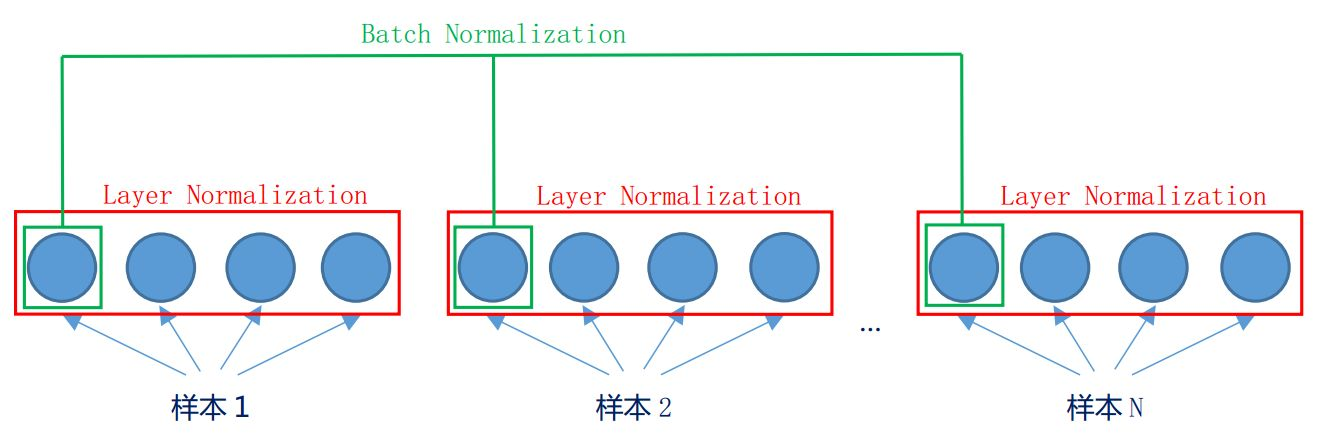
使用 LN 而不是 BN 的原因论文中没有给出，有大量实验表明 BN 不适合 NLP，尤其是使用 RNN 的模型

In [ ]:
class SublayerConnection(nn.Module):
    
    def __init__(self, d_model, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, layer):
        return self.norm(x + self.dropout(layer(x)))

定义函数 clones，可以复制多个子层

In [ ]:
import copy

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Encoder/Decoder Layer
- EncoderLayer：将 MultiHeadAttention（自注意力），PositionwiseFeedForward 组合起来
- DecoderLayer：将 MultiHeadAttention（自注意力），MultiHeadAttention（上下文注意力），PositionwiseFeedForward 组合起来

In [ ]:
class EncoderLayer(nn.Module):
    
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_model, dropout), 2)
        self.d_model = d_model

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=mask))
        return self.sublayer[1](x, self.feed_forward)
    
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, context_attn, feed_forward, dropout):
        super().__init__()
        self.d_model = d_model
        self.self_attn = self_attn
        self.context_attn = context_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_model, dropout), 3)
 
    def forward(self, x, enc_output, context_mask, trg_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask=trg_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, enc_output, enc_output, context_mask))
        return self.sublayer[2](x, self.feed_forward)

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x, enc_output, context_mask, trg_mask):
        for layer in self.layers:
            x = layer(x, enc_output, context_mask, trg_mask)
        return x


# Generator
Decoder 在输出 q 查询向量后需要经过一个全连接层和一次 softmax 转化为在词汇表上的概率分布，表示这个位置上各词的概率。为了之后使用KL散度计算与标签的距离，使用了log_softmax 函数

In [ ]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

# Transformer

Xavier初始化方法的目的是让每一层输出的方差尽量相等。初始值从均匀分布

$$U[-\sqrt{\frac{6}{d_{\text {model}}+v}}, \sqrt{\frac{6}{d_{\text {model}}+v}}]$$

中采样。其中 v 是词表(word-piece vocabulary)的大小，论文中给出的WMT 2014 英法数据集上 v = 32000。以$d_{\text {model}}=512$ 为例, 初始值大概是从 U[-0.0136,0.0136] 采样得到, 位置编码中正余弦編可得到的值范围是 [-1,1]，未免会差太多，如果乘上 $\sqrt{d_{m o d e l}}$ , 初值分布将变为 U[ -0.307,0.307]，一定程度上可以缓解这个问题。

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask):
        return self.decode(self.encode(src, src_mask), src_mask,
                            trg, trg_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, enc_output, src_mask, trg, trg_mask):
        return self.decoder(self.trg_embed(trg), enc_output, src_mask, trg_mask)
    
    
def make_model(src_vocab_size, trg_vocab_size, N=6, d_model=512, d_ffn=2048, n_heads=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(d_model, n_heads)
    ffn = PositionwiseFeedForward(d_model, d_ffn, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ffn), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ffn), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab_size), c(position)),
        nn.Sequential(Embeddings(d_model, trg_vocab_size), c(position)),
        Generator(d_model, trg_vocab_size),
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model


# Label Smoothing & Loss Function
> During training, we employed label smoothing of value $ϵ_{ls}=0.1$. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

Label Smoothing 是一种正则化技术，目的是为了提高模型的泛化能力，本质上是引入对训练集标签的不信任因素。原本数据集的标签使用独热编码，真值为1，表示对标签的绝对“信任”，现在引入不信任因素，真值为$1-ϵ_{ls}=0.9$。
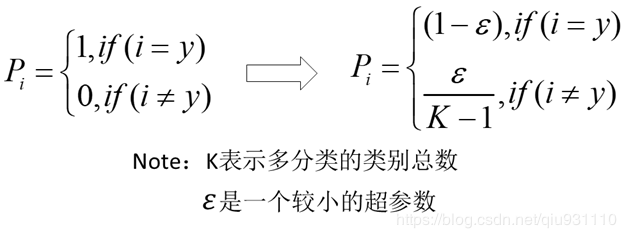
之后使用 KL 散度计算预测分数与平滑后的标签之间的距离，这实际上就是损失函数

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))  # -2 而不是 -1 是因为 <pad> 的概率为 0
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

# Optimizer
> We used the Adam optimizer (cite) with $\beta_{1}=0.9, \beta_{2}=0.98$ and $\epsilon=10^{-9} .$ We varied the learning rate over the course of training, according to the formula: $$lrate =d_{\text {model }}^{-0.5} \cdot \min (\text {step_} \text {num}^{-0.5}, \text {step_num} \cdot \text {warmup_steps}^{-1.5})$$ This corresponds to increasing the learning rate linearly for the first $\operatorname{warmup}_{steps}=4000$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used $\operatorname{warmup}_{steps}=4000$

实际上一个以 $warmup_{steps}$ 为分界点的分段函数。论文中训练用的 batch_size 差不多是20000，对于这种超大 batch，warmup 是一个极其重要的策略。其中，线性增加的方法称为 gradual warmup，使用固定值的方法称为 constant warmup。后者的缺点是在 warmup 阶段结束时，学习率会有一次跳动抬升。

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, d_model, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor  # 用来调节学习率的整体大小
        self.d_model = d_model
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.d_model ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
import matplotlib.pyplot as plt

opts = [NoamOpt(512, 2, 4000, None), 
        NoamOpt(512, 2, 8000, None),
        NoamOpt(256, 2, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

# 查看学习率随 step_num 的变化

# Loss Computation


In [ ]:
class LossComputation:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, label, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              label.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm.float()

# Data Preprocessing
使用tochtext 的Multi30k 数据集，下载WMT 2016 的30000个英德句对。torchtext有几个类可以将句子预处理为NLP建模的常用格式：
- Field：指定每个句子的预处理方法，使用Spacy做tokenization
- TranslationDataset：内置多种翻译数据集，使用Field对象对数据预处理，将源语句与目标语句绑定，可拆分训练集/验证集/测试集
- BucketIterator：把数据集分割成可迭代的批次（batch），同时尽量使长度相近的句子处于同一批次，减少pad个数

此外还使用Spacy 这一nlp常用库，Spacy可以帮助我们对各种语言做tokenization

在运行下面的代码前，要先安装spacy，还要下载en_core_web_sm，de_core_news_sm这两个tokenizer，我的做法是使用校园V披N到这个地址把库下载到本地：

https://vpn.bupt.edu.cn/https/github.com/explosion/spacy-models/releases/tag/de_core_news_sm-2.2.5

解压后再使用`pip install --user-local 存放路径`安装到当前环境

In [ ]:
import spacy
from torchtext.data import Field, BucketIterator
from torchtext.datasets import Multi30k

KEY_EOS = '<eos>'
KEY_SOS = '<sos>'

SRC = Field(tokenize="spacy",
            tokenizer_language="de_core_news_sm",
            init_token=KEY_SOS,
            eos_token=KEY_EOS,
            batch_first=True)
TRG = Field(tokenize="spacy",
            tokenizer_language="en_core_web_sm",
            init_token=KEY_SOS,
            eos_token=KEY_EOS,
            batch_first=True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

print('train_data:', len(train_data))
print('valid_data:', len(valid_data))
print('test_data:', len(test_data))

构建训练集的词汇表，将每个单词符号关联到一个整数上（numericalizing），这样就可以用这个整数来表示该单词

查看词汇表大小和前20个单词符号，注意前4个符号，任一句子会被处理成类似 \[2, ...(other), 3, 1, ..., 1\] 的向量，即 \[sos, ...content..., eos, pad, ..., pad\]

In [ ]:
SRC.build_vocab(train_data.src, min_freq = 2) # 出现频率小于2次的视为 <unk>
TRG.build_vocab(train_data.trg, min_freq = 2)

print('德语词汇表大小：', len(SRC.vocab), ',前20个：', SRC.vocab.itos[0:20])
print('英语词汇表大小：', len(TRG.vocab), ',前20个：', TRG.vocab.itos[0:20])

UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

for i, batch in enumerate(train_iterator):
    # 打印第一个批次，[BACTH_SIZE, seq_len]
    if i < 1 :
        print(batch.src)
        print(batch.src.size())
        print(batch.trg)
        print(batch.trg.size())


# Mask
- pad 只是为了对齐同一 batch 下不同句子的长度，与句子的语义无关，因此在训练的时候应该把 pad 屏蔽
- 测试时，decoder 把上一次的输出加入到下一次的输入中，直到输出是 \<eos\>。训练时，则需要将 target sequence 从\<sos\>开始，递增地输入。在实做中用下面这种 mask 屏蔽掉当前预测位置后面的信息

In [ ]:
def get_subsequent_mask(d_model):
    return (1 - torch.triu(torch.ones((1, d_model, d_model)), diagonal=1)).bool()
    
def get_trg_mask(trg, pad):
    "Create a mask to hide padding and future words."
    trg_mask = (trg != pad).unsqueeze(-2)
    trg_mask = trg_mask & Variable(
        get_subsequent_mask(trg.size(-1)).type_as(trg_mask.data)
    )
    return trg_mask

class Batch:
    def __init__(self, src, trg, pad=1):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        self.trg = trg[:, :-1]
        self.trg_y = trg[:, 1:]
        self.trg_mask = get_trg_mask(self.trg, pad)
        self.n_tokens = (self.trg_y != pad).sum()  # 记录字符数

def rebatch(batch, pad_idx):
    return Batch(batch.src, batch.trg, pad_idx)


plt.figure(figsize=(5,5))
plt.imshow(get_subsequent_mask(20)[0])

# Train

In [ ]:
import time

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        batch = rebatch(batch, PAD_IDX)
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.n_tokens)
        
        total_loss += loss.numpy()
        total_tokens += batch.n_tokens.numpy()
        tokens += batch.n_tokens.numpy()
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss.numpy() / batch.n_tokens.numpy(), tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens


model = make_model(len(SRC.vocab), len(TRG.vocab), N=6)

opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

criterion = LabelSmoothing(size=len(TRG.vocab), padding_idx=PAD_IDX, smoothing=0.1)

EPOCH = 3

for epoch in range(EPOCH):
    model.train()
    run_epoch(train_iterator, 
              model, 
              LossComputation(model.generator, criterion, opt=opt)
    )
    model.eval()
    loss = run_epoch(valid_iterator, 
                  model, 
                  LossComputation(model.generator, criterion, opt=None)
    )
    print(loss)

In [ ]:
def greedy_decode(model, src, src_mask):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(SOS_IDX).type_as(src.data)
    for i in range(src.size(1) - 1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(get_subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=1)
    return ys

In [ ]:
for i, batch in enumerate(valid_iterator):
    print(i, end='\n')
    print(batch.src.size())
    src = batch.src
    
    print("Source:", end="\t")
    for i in range(1, src.size(1)):
        sym = SRC.vocab.itos[src[0, i]]
        if sym == KEY_EOS: break
        print(sym, end =" ")
    print()
        
    src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask)
    
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, i]]
        if sym == KEY_EOS: break
        print(sym, end =" ")
    
    print()
    
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(1)):
        sym = TRG.vocab.itos[batch.trg[0, i]]
        if sym == KEY_EOS: break
        print(sym, end =" ")
    print()

对实验结果的分析：使用 greedy decoding 会让模型输出的句子过于冗余。而且可能因为模型 train 的次数不够再加上用的是greedy decoding，模型每次输出的句子都是一样的。

参考：

[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

[jadore801120/attention-is-all-you-need-pytorch](https://github.com/jadore801120/attention-is-all-you-need-pytorch)

[The Illustrated Transformer【译】](https://blog.csdn.net/yujianmin1990/article/details/85221271)

[Transformer的细枝末节](https://zhuanlan.zhihu.com/p/60821628)